# **Tarea 1 Sistemas Recomendadores**


---


## IIC3633 | 2021-2
Recomendación no personalizada, basada en feedback implícito y basada en contenido.

Alumnos
- Víctor Tirreau - 17637171
- Diego Iruretagoyena - 14619164

Dataset: Anime Recommendation Database  [ Anime Recommendation Database]( https://www.kaggle.com/hernan4444/)


- [X] [Set-up inicial](#set)
- [X] [Actividad 1: Exploración de Datos](#ac01)
- [X] [Actividad 2: Recomendación no personalizada](#ac02)
- [X] [Actividad 3: Recomendación basada en feedback implícito](#ac03)
- [X] [Actividad 4: Recomendación basada en contenido](#ac04)
- [X] [Actividad 5: Comparación de métodos](#ac05)
- [X] [Actividad 6: Ejemplos de recomendación](#ac06)

Este trabajo puede encontrarse en mejor formato en un  [Google Colab](https://colab.research.google.com/drive/1ljA1Ol2o-NYPijDBhaDiBZ2nvzwMqVbJ?usp=sharing)



## Set-up inicial 
<a id='set'></a>

In [1]:
!pip3 install tqdm --upgrade
!pip3 install implicit --upgrade
!pip3 install pyreclab --upgrade

     |████████████████████████████████| 76 kB 2.7 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.0
    Uninstalling tqdm-4.62.0:
      Successfully uninstalled tqdm-4.62.0
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4503589 sha256=097cbfdab3ad0c1843d10d8893aa8689176e27b9917a0442631056c95b99fc37
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit
     |████████████████████████████████| 234 kB 5.1 MB/s 


In [2]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, ndcg_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import scipy.sparse as sparse


import seaborn as sns
import pandas as pd
import numpy as np
import pyreclab
import implicit
import heapq
import time
import json
import tqdm as tqdm
import math

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Lectura de input

BASE_PATH = '/content/drive/MyDrive/10Sem/RecSys/tarea1-recsyspuc-2021-readme-md/'

test_users_df = pd.read_csv(BASE_PATH + 'test_users.csv')
train_df = pd.read_csv(BASE_PATH + 'train.csv')
validation_df = pd.read_csv(BASE_PATH + 'val.csv')
anime_info = np.load(BASE_PATH + 'anime_info.pkl', allow_pickle=True)

## **Actividad 1: Exploración de datos**
<a id='exploracion'></a>
En esta actividad se presentan gráficos de distribución de usuarios y animes.

Además, se realiza un análisis de las variables con las que contamos en el dataset, entregando métricas como promedio, desviación estándar y densidad.

In [ ]:
test_users_df.head()

,Unnamed: 0,user_id
0,0,125862
1,1,246612
2,2,925
3,3,136160
4,4,174689


In [ ]:
train_df.head()

,user_id,anime_id,rating
0,290025,36793,8
1,166392,30123,8
2,57349,16774,9
3,147605,22763,9
4,16310,15699,5


In [ ]:
anime_info.head()

,anime_id,Name,Genres,Synopsis,content,content_embeddings
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever...",cowboy bebop action adventure comedy drama sci...,"[-0.033500284, 0.03323533, 0.034192204, -0.049..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ...",cowboy bebop tengoku no tobira action drama my...,"[-0.035846457, 0.022955496, 0.012560053, -0.03..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0...",trigun action sci fi adventure comedy drama sh...,"[0.051486682, -0.060088806, -0.029781044, -0.0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...,witch hunter robin action mystery police super...,"[-0.0076218257, -0.026781121, 0.05598651, 0.00..."
4,15,Eyeshield 21,"Action, Sports, Comedy, Shounen",Sena is like any other shy kid starting high s...,eyeshield 21 action sports comedy shounen sena...,"[-0.04619904, -0.053223185, -0.06296745, -0.03..."


In [ ]:
validation_df.head()

,user_id,anime_id,rating
0,50106,28883,7
1,100033,8514,6
2,301396,1726,5
3,324857,853,7
4,144230,31442,5


In [ ]:
rated_animes_count = train_df.user_id.value_counts()
reversed_rated = train_df.user_id.value_counts(ascending=True)
rated_animes_count.values

array([134, 131, 129, ...,  42,  41,  40])

### Gráfico distribución del número de interacciones por usuario

Gran parte de los usuarios ha registrado entre 60 y 100 recomendaciones de anime, con una distribución similar a una gaussiana. De hecho, la funcion inversa de la CDF de una gaussiana se ve la siguiente forma

![Gaussiana CDF inversa](https://www.researchgate.net/profile/Ray-Cc-Cheung/publication/3338018/figure/fig1/AS:651874000711684@1532430281507/Inverse-cumulative-distribution-function-of-the-Gaussian-distribution.png)

[Imagen sacada de aquí](https://www.researchgate.net/profile/Ray-Cc-Cheung/publication/3338018/figure/fig1/AS:651874000711684@1532430281507/Inverse-cumulative-distribution-function-of-the-Gaussian-distribution.png)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


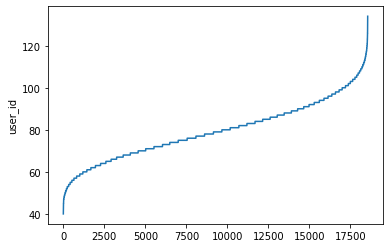

In [ ]:
sns.lineplot(np.arange(len(rated_animes_count)), reversed_rated)

Con respecto al histograma, se confirma la sospecha de la forma Gaussiana en la distribución, con una pequeña anormalidad en torno a 85 - 90 ratings.

Además, se observa una leve asimetría a la izquierda.

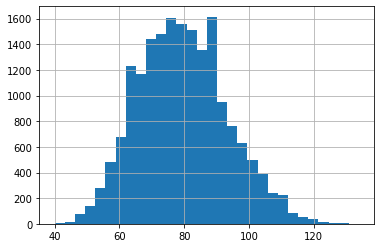

In [ ]:
rated_animes_count.hist(bins=30)

Podemos observar que los usuarios que mas animes han evaluado tienen entre 128 y 134 items distintos.

In [ ]:
rated_animes_count.head(5)

297988    134
469       131
6088      129
214484    129
303684    128
Name: user_id, dtype: int64

La cantidad de usuarios unicos es 18.552

In [ ]:
len(rated_animes_count)

18552

### Usuarios más activos

Podemos observar que los IDs de los cinco usuarios más activos son (297988, 469, 6088, 214484, 303684)

In [ ]:
top_5_users =  rated_animes_count.head(5).sum()
total_reviews = rated_animes_count.sum()
percentage_top_5 = (top_5_users / total_reviews) * 100
percentage_top_5

0.04413394754771856

Podemos observar que el porcentaje de participación en reviews de los top 5 usuarios **no es relevante** con respecto a el resto de los usuarios

### Gráfico de la distribución de interacciones por animé.

En el caso de los animes, podemos observar que los cinco animes más rateados por los usuarios representan un 1% del total de ratings.

In [ ]:
total_animes_reviewed = train_df.anime_id.value_counts()
top_5_animes =  total_animes_reviewed.head(5).sum()
cumulative_sum_animes = total_animes_reviewed.sum()
percentage_top_5 = (top_5_animes / cumulative_sum_animes) * 100
percentage_top_5

1.0080302090430526

In [ ]:
total_animes_reviewed.head(5)

16498    3119
11757    3108
6547     2923
1535     2876
19815    2843
Name: anime_id, dtype: int64

### Animes más populares

Podemos observar que los IDs de los cinco animes más populares son [16498, 11757, 6547, 1535, 19815], los que corresponden a los siguientes animes:


In [ ]:
anime_info[anime_info.anime_id.isin([16498, 11757, 6547, 1535, 19815])][['anime_id', 'Name']]

,anime_id,Name
411,1535,Death Note
768,6547,Angel Beats!
1092,11757,Sword Art Online
1278,16498,Shingeki no Kyojin
1399,19815,No Game No Life


**Podemos observar que la distribución de evaluaciones por anime asimila a una Exponencial**

Ejemplo Distribucion Exponencial

![Ejemplo Distribucion Exponencial](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Exponential_distribution_pdf.png/640px-Exponential_distribution_pdf.png )


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


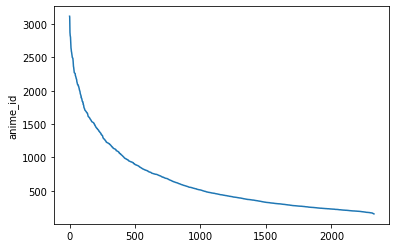

In [ ]:
sns.lineplot(np.arange(len(total_animes_reviewed)), total_animes_reviewed)

Sobre el histograma, podemos confirmar que tiene un comportamiento Exponencial

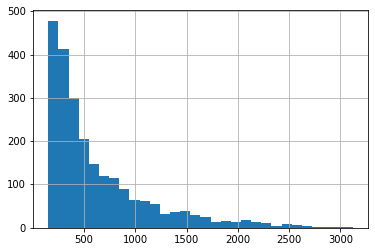

In [ ]:
total_animes_reviewed.hist(bins=30)

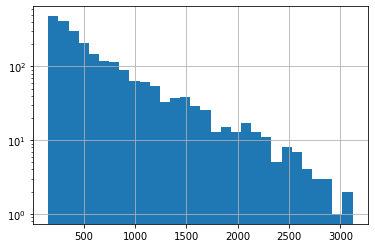

In [ ]:
total_animes_reviewed.hist(bins=30, log=True)

Genere una tabla con la cantidad de usuarios distintos, número de items distintos, promedio y desviación estándar de animes por usuario, promedio y desviación estándar de usuarios por animes y densidad del dataset (o sparsity) en cuanto a interacciones.

In [ ]:
train_df.head()

,user_id,anime_id,rating
0,290025,36793,8
1,166392,30123,8
2,57349,16774,9
3,147605,22763,9
4,16310,15699,5


In [ ]:
unique_user_count = train_df.user_id.unique().shape[0]
unique_anime_count = train_df.anime_id.unique().shape[0]
average_reviews_by_users = rated_animes_count.mean()
std_reviews_by_users = rated_animes_count.std()
average_reviews_per_anime = total_animes_reviewed.mean()
std_reviews_per_anime = total_animes_reviewed.std()

print("""Cantidad usuarios total: {0}, 
Animes distintos {1}, 
Promedio animes por usuario {2:.2f}, 
STD animes por usuario {3:.2f}, 
Promedio reviews por anime {4:.2f}, 
STD reviews por anime {5:.2f}""".format(unique_user_count, unique_anime_count, average_reviews_by_users, std_reviews_by_users, average_reviews_per_anime, std_reviews_per_anime))

Cantidad usuarios total: 18552, 
Animes distintos 2326, 
Promedio animes por usuario 79.51, 
STD animes por usuario 13.70, 
Promedio reviews por anime 634.16, 
STD reviews por anime 513.60


In [ ]:
total_train_count = train_df.shape[0]
total_train_count

density = total_train_count / (unique_user_count * unique_anime_count)
print("Podemos observar que es un dataset de baja densidad del {0:.2%}, dejando sparsity con valor {1:.2%}".format(density, (1 - density)))

Podemos observar que es un dataset de baja densidad del 3.42%, dejando sparsity con valor 96.58%


## **Actividad 2: Recomendación no personalizada**
<a id='ac02'></a>
Most popular y random.

Comenzamos analizando el comportamiento de los datos en el dataset de validación,

In [15]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [ ]:
validation_df.head()

,user_id,anime_id,rating
0,50106,28883,7
1,100033,8514,6
2,301396,1726,5
3,324857,853,7
4,144230,31442,5


In [ ]:
validation_df.user_id.unique().shape[0]

14751

In [ ]:
validation_unique_users = validation_df.user_id.unique()
train_unique_users = train_df.user_id.unique()
print(validation_unique_users.shape, train_unique_users.shape)

(14751,) (18552,)


In [ ]:
len(set(validation_unique_users)&set(train_unique_users))

14751

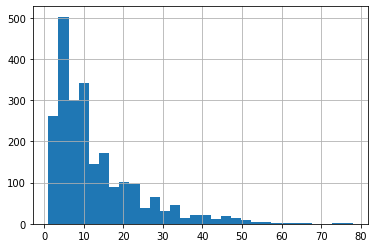

In [ ]:
validation_df.anime_id.value_counts().hist(bins=30)

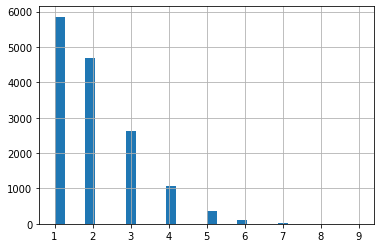

In [ ]:
validation_df.user_id.value_counts().hist(bins=30)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


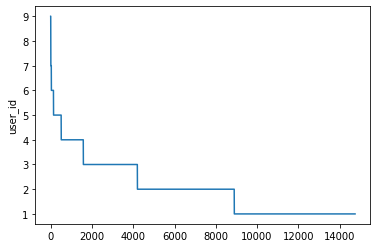

In [ ]:
sns.lineplot(np.arange(len(validation_df.user_id.unique())), validation_df.user_id.value_counts())

In [ ]:
train_top_animes = train_df.anime_id.value_counts()
train_top_animes.head(10).index

validation_df.user_id.value_counts

<bound method IndexOpsMixin.value_counts of 0         50106
1        100033
2        301396
3        324857
4        144230
          ...  
30097    150204
30098    144072
30099    279887
30100    290160
30101     72457
Name: user_id, Length: 30102, dtype: int64>

In [ ]:
validation_df[validation_df.user_id == 321265]

,user_id,anime_id,rating
6083,321265,22297,10
9475,321265,9181,7
11479,321265,30654,8
12277,321265,11741,10
14157,321265,21563,8
17808,321265,28851,9
18341,321265,33018,7
20406,321265,71,10
25684,321265,31181,9


### Most popular

In [ ]:
# Definicion de objeto "most popular"

most_popular = pyreclab.MostPopular(dataset= BASE_PATH + 'train.csv',
                   dlmchar=b',',
                   header=True,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

most_popular.train()

In [ ]:
# Testing de recomendaciones sobre los primeros N items 

most_popular_results = []
for top_n in [10, 20, 30]:
  recommendList, maprec, ndcg = most_popular.testrec(input_file= BASE_PATH + 'val.csv',
                                            dlmchar=b',',
                                            header=True,
                                            usercol=0,
                                            itemcol=1,
                                            ratingcol=2,
                                            topn=top_n,
                                            relevance_threshold=7,
                                            includeRated=False)
  most_popular_results.append([top_n, maprec, ndcg])

  print('MAP{}: {}\nNDCG@{}: {}'.format(top_n, maprec, top_n, ndcg))

MAP10: 0.011026788162501026
NDCG@10: 0.012204016195495711
MAP20: 0.012845817079542694
NDCG@20: 0.01741654601711174
MAP30: 0.013672311785931094
NDCG@30: 0.021628328883578216


In [ ]:
processed_most_popular = []
for (top_n, map, ndcg) in most_popular_results:
  processed_most_popular.append((top_n, map, 'map'))
  processed_most_popular.append((top_n, ndcg, 'ndcg'))

most_popular_df = pd.DataFrame(processed_most_popular, columns=['rank_', 'result', 'evaluation'])
most_popular_df

,rank_,result,evaluation
0,10,0.011027,map
1,10,0.012204,ndcg
2,20,0.012846,map
3,20,0.017417,ndcg
4,30,0.013672,map
5,30,0.021628,ndcg


In [ ]:
most_popular_df.to_csv("mostpopular_results.csv")

In [47]:
most_popular_df = pd.read_csv("mostpopular_results.csv")

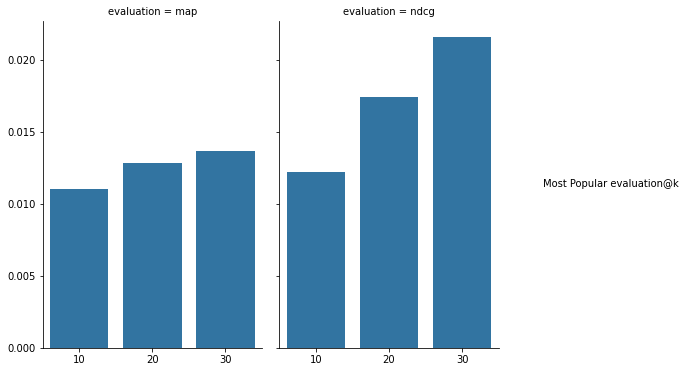

In [ ]:
# Gráficos Most Popular

g = sns.FacetGrid(most_popular_df, col='evaluation')
g.map_dataframe(sns.barplot, x='rank_', y='result', ci=None)
g.add_legend(title="Most Popular evaluation@k")
plt.gcf().set_size_inches(10, 6)
plt.savefig("most-popular-rank-sensibility.png")

In [50]:
def custom_precision(retrieved, relevant):
  if not len(retrieved):
    return 0

  true_positives = len(set(retrieved)&set(relevant))
  return true_positives / len(retrieved)

def custom_recall(retrieved, relevant):
  if not len(relevant):
    return 0
    
  true_positives = len(set(retrieved)&set(relevant))
  return true_positives / len(relevant)


### Random

In [51]:
def random_recommendation(current_user_id, size_=30):
  # Which animes did this user already rate ?
  rated_animes_by_user = train_df[train_df.user_id == current_user_id].anime_id.unique()
  # Select random choices from the whole list minus the ones that user already recommended
  choices = np.random.choice(train_df.anime_id.unique(), size=170, replace=False)
  filtered = [random_anime for random_anime in choices if random_anime not in rated_animes_by_user][0:30]

  return filtered

obtained_random_recalls = []
obtained_random_precisions = []
obtained_mean_map = {10: 0, 20: 0, 30: 0}
obtained_mean_ndcg = {10: 0, 20: 0, 30: 0}

# Make a partition of train/validation dbs, obtaining only animes rated equally or over 7
relevant_animes_VALIDATION = validation_df[(validation_df.rating >= 7)]
relevant_animes_TRAIN = train_df[(train_df.rating >= 7)]

# for each user present in validation, do a random recommendation and evaluate precision/recall
for user in tqdm.tqdm(validation_df.user_id.unique()):
  actual_relevant_items = relevant_animes_VALIDATION[(relevant_animes_VALIDATION.user_id == user)].anime_id
  random_rec = random_recommendation(user)

  for k in [10, 20, 30]:
    rel_vector = [np.isin(random_rec[0: k], actual_relevant_items, assume_unique=True).astype(int)]
    cutted_vector = rel_vector[0][0: k].reshape(1, -1)
    mn_Average = mean_average_precision(cutted_vector) 
    obtained_mean_map[k] += mn_Average
    obtained_mean_ndcg[k] += ndcg_at_k(rel_vector, k)

  # Precision
  current_random_precision = custom_precision(retrieved=random_rec, relevant=actual_relevant_items)
  obtained_random_precisions.append(current_random_precision)

  # Recall
  current_random_recall = custom_recall(retrieved=random_rec, relevant=actual_relevant_items)
  obtained_random_recalls.append(current_random_recall)
  
fast_mean_random_recall = np.array(obtained_random_recalls).mean()
fast_mean_random_precision = np.array(obtained_random_precisions).mean()

len_uniques = len(validation_df.user_id.unique())
for k in [10, 20, 30]:
  obtained_mean_map[k] /= len_uniques
  obtained_mean_ndcg[k] /= len_uniques

print(fast_mean_random_recall, fast_mean_random_precision)
print(obtained_mean_map, obtained_mean_ndcg)


100%|██████████| 14751/14751 [03:51<00:00, 63.59it/s]

0.012608830394065292 0.0007570108241249182
{10: 0.0020011825940237566, 20: 0.002488360105253322, 30: 0.0028166855370088412} {10: 0.007050369466476849, 20: 0.014168530947054437, 30: 0.02237136465324385}


In [52]:
random_mean_map = obtained_mean_map
random_mean_ndcg = obtained_mean_ndcg

In [53]:
print(fast_mean_random_recall, fast_mean_random_precision)

0.012608830394065292 0.0007570108241249182


In [54]:
random_results_list = [(k, v, 'map') for (k, v) in random_mean_map.items()] + [(k, v, 'ndcg') for (k, v) in random_mean_ndcg.items()]
random_df = pd.DataFrame(random_results_list, columns=['rank_', 'result', 'evaluation'])

In [55]:
random_df.to_csv("random_results.csv")

In [ ]:
random_df = pd.read_csv("random_results.csv")

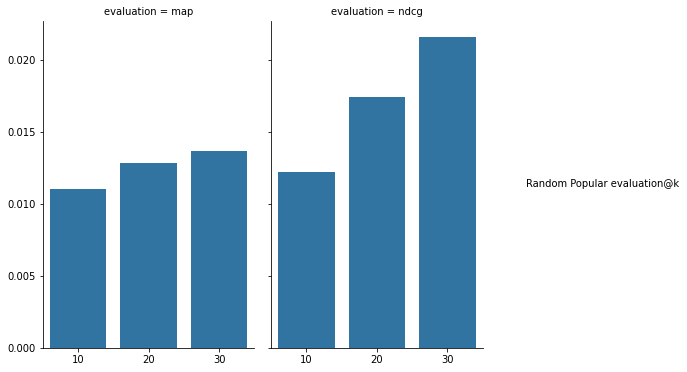

In [173]:
# Gráficos Random

g = sns.FacetGrid(random_df, col='evaluation')
g.map_dataframe(sns.barplot, x='rank_', y='result', ci=None)
g.add_legend(title="Random evaluation@k")
plt.gcf().set_size_inches(10, 6)
plt.savefig("random-rank-sensibility.png")

### Explicación método random

Para optimizar el tiempo de ejecución, en lugar de elegir de forma aleatoria entre los items no rateados por usuario, lo cual demoraba 40+ minutos, obtuvimos una lista de 170 elementos de forma aleatoria, para luego filtrar vs la lista que dicho usuario si dió feedback. 

Así, redujimos los tiempos a 3 mins.

## **Actividad 3 Recomendación basada en feedback implícito**
<a id='ac03'></a>
ALS y BPR junto a un análisis de sensibilidad.

Para utilizar estos métodos, necesitamos crear una sparse matrix con nuestra información, para luego evaluar cada modelo.

In [9]:
# Desde Práctico Implicit_feedback
# Creamos una Sparse Matrix para utilizar ALS y BPR

user_animes = {}
animes_set = set()

for row in train_df.itertuples():
    
    if row[1] not in user_animes:
        user_animes[row[1]] = []
        
    user_animes[row[1]].append(row[2])
    animes_set.add(row[2])

animes_list = np.sort(list(animes_set))
sparse_matrix = np.zeros((len(user_animes), len(animes_set)))

for i, animes in enumerate(user_animes.values()):
    sparse_matrix[i] = np.isin(animes_list, animes, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_df_to_incr_ids = {key: i for i, key in enumerate(user_animes.keys())}
user_incr_ids_to_df = dict(enumerate(user_animes.keys()))
anime_df_to_incr_ids = {key: i for i, key in enumerate(animes_list)}
anime_incr_ids_to_df = dict(enumerate(animes_list))
user_item_matrix = matrix.T.tocsr()

In [ ]:
len(user_animes[297988])
user_df_to_incr_ids[297988]

1950

In [10]:
user_animes_val = {}

for row in validation_df.itertuples():
    if row[1] not in user_animes_val:
        user_animes_val[row[1]] = []
        
    user_animes_val[row[1]].append(row[2])

In [ ]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_animes_val.keys():
    if u not in user_df_to_incr_ids:
        continue
    remapped_user = user_df_to_incr_ids[u]
    rec = [anime_incr_ids_to_df[t[0]] for t in model.recommend(remapped_user, user_item_matrix, n)]
    rel_vector = [np.isin(rec, user_animes_val[u], assume_unique=True).astype(int)]
    # rel_vector = np.isin(user_animes_val[u], rec, assume_unique=True).astype(int).reshape(1,-1)
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_animes_val)
  mean_ndcg /= len(user_animes_val)
  
  return mean_map, mean_ndcg

In [ ]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return recommendations

### Alternate Least Squares

In [38]:
%cd /content/drive/MyDrive/10Sem/RecSys/tarea1-recsyspuc-2021-readme-md/

/content/drive/MyDrive/10Sem/RecSys/tarea1-recsyspuc-2021-readme-md


In [ ]:
!ls

In [ ]:
def ALS_metrics():
  ALS_results = {}
  for latent_factor in [50, 100, 200, 500, 1000]:
    for max_iter in [10, 20, 30, 40, 50]:
        t0 = time.time()
        model_als = implicit.als.AlternatingLeastSquares(factors=latent_factor, iterations=max_iter, use_gpu=True)
        model_als.fit(matrix)
        for ndcg_rank in [10, 20, 30]:
            maprec, ndcg = evaluate_model(model_als, n=ndcg_rank)
            ALS_results[latent_factor, max_iter, ndcg_rank] = [maprec, ndcg, time.time() - t0]

  return ALS_results


### Factorización Matricial optimizada con Bayesian Personalized Ranking

In [ ]:
def BPR_metrics():
  BPR_results = {}
  for latent_factor in tqdm.tqdm([50, 100, 200, 500, 1000]):
      for max_iter in range(10, 810, 50):
        t0 = time.time()
        model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=latent_factor, iterations=max_iter, use_gpu=True)
        model_bpr.fit(matrix)
        for ndcg_rank in [10, 20, 30]:
            maprec, ndcg = evaluate_model(model_bpr, n=ndcg_rank)
            BPR_results[latent_factor, max_iter, ndcg_rank] = [maprec, ndcg, time.time() - t0]

  return BPR_results

In [ ]:
als_results = ALS_metrics()

In [ ]:
bpr_results = BPR_metrics()

In [ ]:
bpr_results_processed = [list(k) + v for k,v in bpr_results.items()]
bpr_results_df = pd.DataFrame(bpr_results_processed, columns=["latent_factors", "max_iter", "rank_", "map", "ndcg", "time"])
als_results_processed = [list(k) + v for k,v in als_results.items()]
als_results_df = pd.DataFrame(als_results_processed, columns=["latent_factors", "max_iter", "rank_", "map", "ndcg", "time"])

In [ ]:
# als_results_df.to_csv("ALS_results.csv")
# bpr_results_df.to_csv("BPR_results.csv")

In [42]:
als_results_df = pd.read_csv("ALS_results.csv").drop(columns=["Unnamed: 0"])
bpr_results_df = pd.read_csv("BPR_results.csv").drop(columns=["Unnamed: 0"])

In [43]:
# Plot de ALS; BPR en ranking 10
bpr_results_df["method"] = "BPR"
als_results_df["method"] = "ALS"

processed_BPR_ALS_results_dataframe = pd.concat([bpr_results_df, als_results_df])
rank_10 = processed_BPR_ALS_results_dataframe[processed_BPR_ALS_results_dataframe.rank_ == 10]


In [44]:
processed_BPR_ALS_results_dataframe

,latent_factors,max_iter,rank_,map,ndcg,time,method
0,50,10,10,0.009271,0.033218,5.181061,BPR
1,50,10,20,0.010849,0.056403,10.518459,BPR
2,50,10,30,0.011381,0.071588,16.205203,BPR
3,50,60,10,0.011005,0.035320,5.681611,BPR
4,50,60,20,0.013020,0.066301,11.065298,BPR
...,...,...,...,...,...,...,...
70,1000,40,20,0.010393,0.045895,28.137490,ALS
71,1000,40,30,0.011034,0.063114,35.531725,ALS
72,1000,50,10,0.009583,0.026846,25.806581,ALS
73,1000,50,20,0.010893,0.047115,32.506565,ALS


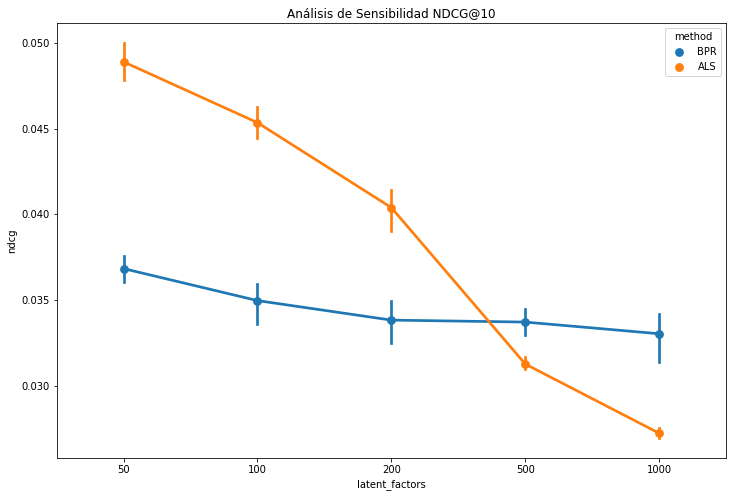

In [ ]:
sns.pointplot(data=rank_10, x='latent_factors', y='ndcg', hue='method')
plt.title("Análisis de Sensibilidad NDCG@10");
plt.gcf().set_size_inches(12, 8)
plt.savefig("ndcg10-mf-sensibility.png")

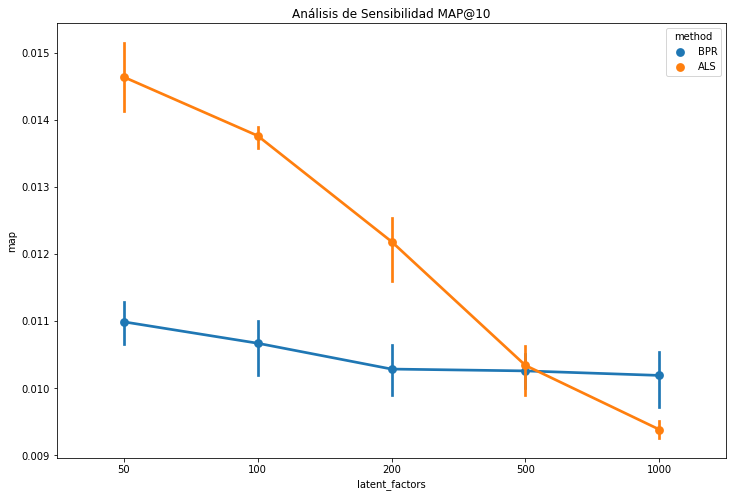

In [ ]:
sns.pointplot(data=rank_10, x='latent_factors', y='map', hue='method')
plt.title("Análisis de Sensibilidad MAP@10");
plt.gcf().set_size_inches(12, 8)
plt.savefig("map10-mf-sensibility.png")

Analizamos experimentalmente el rendimiento en función de la cantidad de iteraciones de entrenamiento. Así, dedujimos que para la convergencia de ALS requerimos menos de 30 iteraciones, mientras que BPR requiere alrededor de 100.

Fijándonos en la misma cantidad de iteraciones,
observamos que el rendimiento en tiempo en función de la cantidad 
de factores latentes es muchísimo mejor en BPR que ALS.

Cabe mencionar que todos los tiempos reportados corresponden a
segundos y que los algoritmos de entrenamiento fueron acelerados mediante GPU.

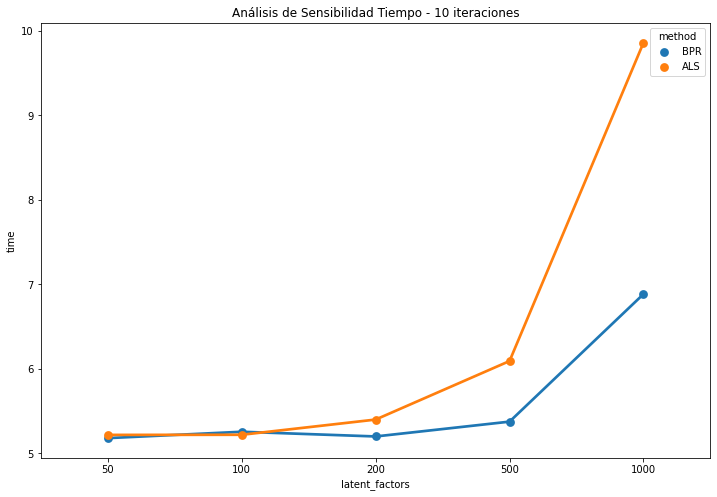

In [ ]:
sns.pointplot(data=rank_10[rank_10.max_iter == 10], x='latent_factors', y='time', hue='method')
plt.title("Análisis de Sensibilidad Tiempo - 10 iteraciones");
plt.gcf().set_size_inches(12, 8)
plt.savefig("mf-time-sensibility.png")

## **Actividad 4: Recomendación basada en contenido**
<a id='ac04'></a>


In [168]:
anime_embeddings = np.vstack(anime_info.content_embeddings.to_numpy())

In [169]:
# Tomado desde practico "Content_Based_texto"

# dict index 2 book id and vice-versa for recommendation 
idx2animeid = {i: id_ for i, id_ in enumerate(anime_info.anime_id)}
animeid2idx = {id_:i for i, id_ in enumerate(anime_info.anime_id)}

def recommend_to_user(anime_embedding_PCA, user_id, metric='euclidean', topk=10):
  # Encontrar IDs de animes que evaluó este usuario
  evaluated_animes = train_df[train_df.user_id == user_id].anime_id
  # Convertirlos a IDs secuenciales que creamos para la indexar matriz
  anime_index = [animeid2idx[i] for i in evaluated_animes]
  # Construir matriz de embeddings de animes que evaluó usuario
  user_rated_animes_embeddings = anime_embedding_PCA[anime_index, :]
  # Calcular promedio de embeddings
  user_embedding = user_rated_animes_embeddings.mean(axis=0)

  n = anime_embedding_PCA.shape[0]
  # Calcular distancias hasta embeddings originales con respecto a promedio
  distances = pairwise_distances(user_embedding.reshape(1, -1), anime_embedding_PCA, metric=metric)

  # Usando cola de prioridades, calculo los K más cercanos
  heap = []
  for i in range(n):            
      if len(heap) < topk:
          heapq.heappush(heap, (-distances[0][i], i))
      else:
          heapq.heappushpop(heap, (-distances[0][i], i))

  heap.sort(reverse=True)
  rec_ids = [idx2animeid[i] for _,i in heap]
  
  return rec_ids

In [170]:
def evaluate_PCA(model, metric_):
  mean_map = {10: 0, 20: 0, 30: 0}
  mean_ndcg = {10: 0, 20: 0, 30: 0}

  for current_user_id in tqdm.auto.tqdm(list(user_animes_val.keys())):
    similar_animes = recommend_to_user(model, user_id = current_user_id, metric = metric_, topk=30)
    rel_vector = [np.isin(similar_animes, user_animes_val[current_user_id], assume_unique=True).astype(int)]
    for k_ in [10, 20, 30]:
      cutted_vector = rel_vector[0][0: k_].reshape(1, -1)
      mean_map[k_] += mean_average_precision(cutted_vector)
      mean_ndcg[k_] += ndcg_at_k(cutted_vector, k_)

  mean_map = {k: v / len(user_animes_val) for k, v in mean_map.items()}
  mean_ndcg = {k: v / len(user_animes_val) for k, v in mean_ndcg.items()}
  
  return mean_map, mean_ndcg

In [171]:
def PCA_simulations():
  results = []
  for n_components in tqdm.auto.tqdm([10, 50, 100]):
    for metric_ in tqdm.auto.tqdm(['cosine', 'euclidean', 'manhattan']):
      reduced_dimensionality_animes = PCA(n_components=n_components).fit_transform(anime_embeddings)
      map_, ndcg = evaluate_PCA(reduced_dimensionality_animes, metric_)

      for rank, score in map_.items():
        results.append([n_components, metric_, rank, score, 'map'])

      for rank, score in ndcg.items():
        results.append([n_components, metric_, rank, score, 'ndcg'])
  return results


In [172]:
PCA_results = PCA_simulations()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14751 [00:00<?, ?it/s]

  0%|          | 0/14751 [00:00<?, ?it/s]

  0%|          | 0/14751 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14751 [00:00<?, ?it/s]

  0%|          | 0/14751 [00:00<?, ?it/s]

  0%|          | 0/14751 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14751 [00:00<?, ?it/s]

  0%|          | 0/14751 [00:00<?, ?it/s]

  0%|          | 0/14751 [00:00<?, ?it/s]

In [81]:
try:
  with open("PCA_results.json") as jsonFile:
    PCA_results = json.load(jsonFile)
    jsonFile.close()
except:
  PCA_results = PCA_simulations()
  with open("PCA_results.json", 'w') as fd:
    json.dump(PCA_results, fd)

print(PCA_results)

[[10, 'cosine', 10, 0.005372866838191224, 'map'], [10, 'cosine', 20, 0.00655746121486703, 'map'], [10, 'cosine', 30, 0.007166547086220068, 'map'], [10, 'cosine', 10, 0.005372866838191224, 'ndcg'], [10, 'cosine', 20, 0.00655746121486703, 'ndcg'], [10, 'cosine', 30, 0.007166547086220068, 'ndcg'], [10, 'euclidean', 10, 0.002476883461223506, 'map'], [10, 'euclidean', 20, 0.0034525840578056707, 'map'], [10, 'euclidean', 30, 0.003950227112714821, 'map'], [10, 'euclidean', 10, 0.002476883461223506, 'ndcg'], [10, 'euclidean', 20, 0.0034525840578056707, 'ndcg'], [10, 'euclidean', 30, 0.003950227112714821, 'ndcg'], [10, 'manhattan', 10, 0.002462787026545418, 'map'], [10, 'manhattan', 20, 0.00328158411342362, 'map'], [10, 'manhattan', 30, 0.003765532860948791, 'map'], [10, 'manhattan', 10, 0.002462787026545418, 'ndcg'], [10, 'manhattan', 20, 0.00328158411342362, 'ndcg'], [10, 'manhattan', 30, 0.003765532860948791, 'ndcg'], [50, 'cosine', 10, 0.006414657924725042, 'map'], [50, 'cosine', 20, 0.0077

### Análisis de sensibilidad de resultados 

In [178]:
PCA_results_dataframe = pd.DataFrame(PCA_results, columns=['n_components', 'metric_', 'rank_', 'result', 'method'])
PCA_map_results = PCA_results_dataframe[PCA_results_dataframe.method == 'map']
PCA_ndcg = PCA_results_dataframe[PCA_results_dataframe.method == 'ndcg']

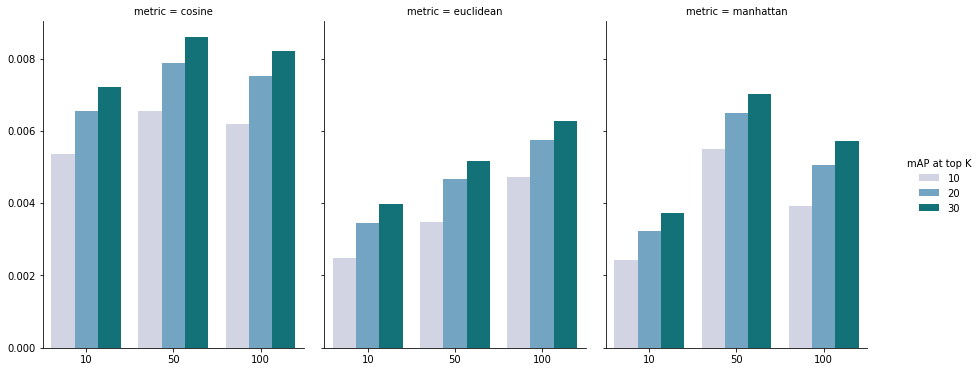

In [179]:
g = sns.FacetGrid(PCA_map_results.rename(columns={"metric_": "metric"}), col='metric')
g.map_dataframe(sns.barplot, x='n_components', y='result', hue='rank_', ci=None, palette="PuBuGn")
g.add_legend(title="mAP at top K")
plt.gcf().set_size_inches(14, 6)
plt.savefig("pca-map-sensibility.png")

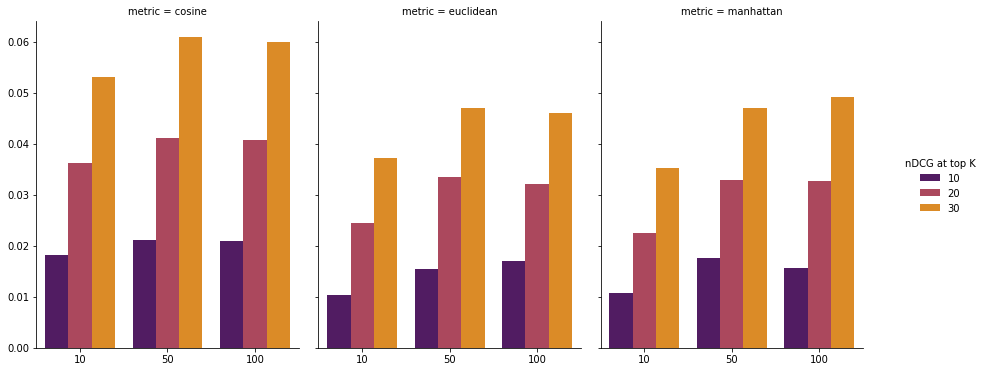

In [180]:
v = sns.FacetGrid(PCA_ndcg.rename(columns={"metric_": "metric"}), col='metric')
v.map_dataframe(sns.barplot, x='n_components', y='result', hue='rank_', ci=None, palette="inferno")
v.add_legend(title="nDCG at top K")
plt.gcf().set_size_inches(14, 6)
plt.savefig("pca-ndcg-sensibility.png")

## **Actividad 5: Comparación de métodos**
<a id='ac05'></a>
- [X] Tabla comparativa de los resultados 
- [X] Análisis y discusión de los resultados
- [X] 10 recomendaciones por cada usuario del dataset de testing

In [181]:
BPR_ALS_MAP_only = processed_BPR_ALS_results_dataframe.drop(columns=["ndcg"]).rename(columns={"map": "result"})
BPR_ALS_NDCG_only = processed_BPR_ALS_results_dataframe.drop(columns=["map"]).rename(columns={"ndcg": "result"})
BPR_ALS_MAP_only["evaluation"] = "map"
BPR_ALS_NDCG_only["evaluation"] = "ndcg"

In [93]:
random_df

,rank_,result,evaluation,method
0,10,0.002001,map,Random
1,20,0.002488,map,Random
2,30,0.002817,map,Random
3,10,0.007050,ndcg,Random
4,20,0.014169,ndcg,Random
5,30,0.022371,ndcg,Random


In [187]:
PCA_ndcg["evaluation"] = "ndcg"
PCA_ndcg['method'] = 'PCA'
PCA_map_results["evaluation"] = "map"
PCA_map_results['method'] = 'PCA'
most_popular_df['method'] = 'Most Popular'
random_df['method'] = 'Random'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [99]:
most_popular_df

,Unnamed: 0,rank_,result,evaluation,method
0,0,10,0.011027,map,Most Popular
1,1,10,0.012204,ndcg,Most Popular
2,2,20,0.012846,map,Most Popular
3,3,20,0.017417,ndcg,Most Popular
4,4,30,0.013672,map,Most Popular
5,5,30,0.021628,ndcg,Most Popular


In [188]:
final_analysis_df = pd.concat([PCA_ndcg, PCA_map_results,  BPR_ALS_MAP_only, BPR_ALS_NDCG_only, most_popular_df, random_df]).reset_index().drop(columns=["Unnamed: 0"])


Ahora buscamos la mejor configuración de hiperparámetros para cada método, en función de su rendimiento en la métrica nDCG@30

### Tabla comparativa de los resultados 

In [189]:
final_analysis_df[(final_analysis_df.evaluation == "ndcg") & (final_analysis_df.rank_ == 30)].sort_values(by='result', ascending=False).groupby(["method", "evaluation"]).head(1)

,index,n_components,metric_,rank_,result,method,evaluation,latent_factors,max_iter,time
620,11,NaN,NaN,30,0.133144,ALS,ndcg,50.0,40.0,16.877897
377,8,NaN,NaN,30,0.102840,BPR,ndcg,50.0,110.0,17.116486
11,23,50.0,cosine,30,0.061013,PCA,ndcg,NaN,NaN,NaN
695,5,NaN,NaN,30,0.022371,Random,ndcg,NaN,NaN,NaN
689,5,NaN,NaN,30,0.021628,Most Popular,ndcg,NaN,NaN,NaN


De manera equivalente, realizamos el análisis para la métrica mAP@30

In [190]:
final_analysis_df[(final_analysis_df.evaluation == "map") & (final_analysis_df.rank_ == 30)].sort_values(by='result', ascending=False).groupby(["method", "evaluation"]).head(1)

,index,n_components,metric_,rank_,result,method,evaluation,latent_factors,max_iter,time
308,14,NaN,NaN,30,0.019522,ALS,map,50.0,50.0,17.007286
92,38,NaN,NaN,30,0.015077,BPR,map,50.0,610.0,21.153168
688,4,NaN,NaN,30,0.013672,Most Popular,map,NaN,NaN,NaN
38,20,50.0,cosine,30,0.008609,PCA,map,NaN,NaN,NaN
692,2,NaN,NaN,30,0.002817,Random,map,NaN,NaN,NaN


In [109]:
final_analysis_df.to_csv('FinalAnalysis.CSV')

In [124]:
best_model_als = implicit.als.AlternatingLeastSquares(factors=50, iterations=40, use_gpu=True)
best_model_als.fit(matrix)

def best_recommender(user: int, n: int):
    remapped_user = user_df_to_incr_ids[user]
    return [int(anime_incr_ids_to_df[t[0]]) for t in best_model_als.recommend(remapped_user, user_item_matrix, n)]

  0%|          | 0/40 [00:00<?, ?it/s]

### Análisis y discusión de los resultados

Se observa a primera vista que los recomendadores random y most-popular constituyen un buen *baseline* con el cual comparar. Como dato anecdótico,
hasta 24 horas antes de la fecha de entrega, el recomendador random
era el mejor método, debido a un error en la recomendación en los métodos
de factorización matricial.
Sin embargo, una vez resuelto, estos métodos superaron con holgura
a los *baselines*.

Un análisis interesante corresponde a la convergencia en función del 
número de iteraciones de entrenamiento para los métodos MF.
En particular, se detectó que a medida que se aumentaba la dimensión
latente, usualmente el rendimiento alcanzaba un máximo y luego decrecía al aumentar las iteraciones. Una hipótesis factible que explica este fenómeno
es la posibilidad de _overfitting_ a mayor cantidad de factores latentes.
De hecho, en los logs de entrenamiento, la mayoría de estos métodos
alcanzaba un AUC extremadamente cercano a 1, por lo que se aprendían
los datos de *train* sin generalizar bien a *validation*.


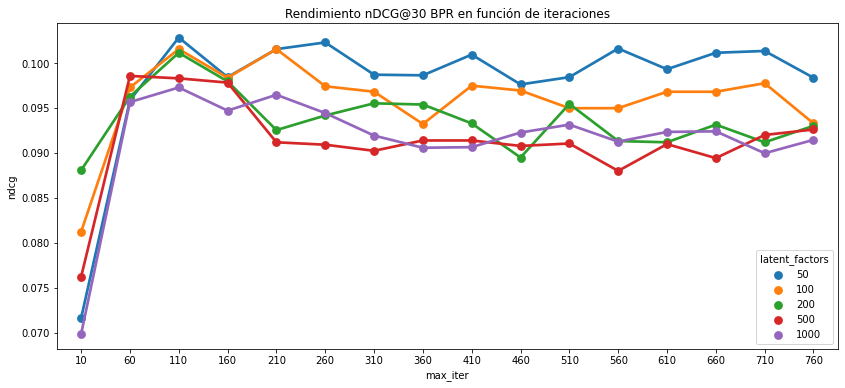

In [183]:
sns.pointplot(data=bpr_results_df[bpr_results_df.rank_==30], x="max_iter", y="ndcg", hue="latent_factors")
plt.title("Rendimiento nDCG@30 BPR en función de iteraciones")
plt.gcf().set_size_inches(14, 6)
plt.savefig("bpr-max-iter-sensibility.png")

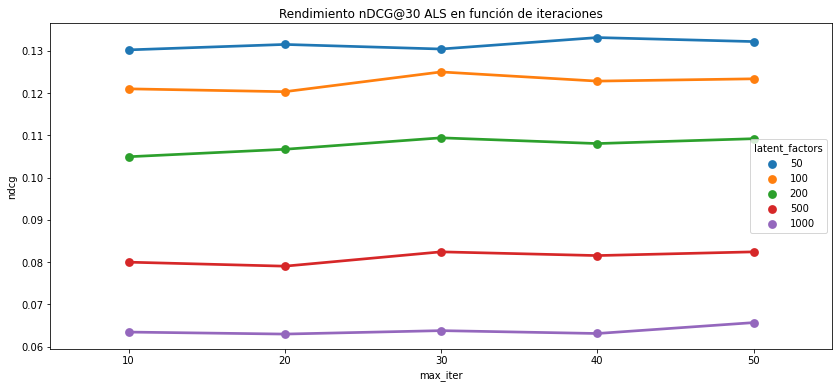

In [184]:
sns.pointplot(data=als_results_df[als_results_df.rank_==30], x="max_iter", y="ndcg", hue="latent_factors")
plt.title("Rendimiento nDCG@30 ALS en función de iteraciones")
plt.gcf().set_size_inches(14, 6)
plt.savefig("als-max-iter-sensibility.png")

### 10 recomendaciones por cada usuario del dataset de testing

In [126]:
rec_results = {}

for user_id in tqdm.tqdm(test_users_df.user_id.unique()):
  rec_results[int(user_id)] = best_recommender(user_id, 10)

with open("test_predictions.json", 'w') as fd:
    json.dump(rec_results, fd, indent=2)

100%|██████████| 14893/14893 [00:05<00:00, 2713.45it/s]


## **Actividad 6: Ejemplos de recomendación de Anime**
<a id='ac06'></a>

- [X] Seleccionar 3 usuarios de ejemplo del dataset de testing y desplegar información de los 10 elementos que le fueron recomendados.
- [X] Seleccionar e indicar animes previamente vistos por cada usuario escogido.
- [X] Comentar brevemente los resultados.

A continuación, revisaremos los usuarios con menor y mayor cantidad de ratings
en train, y así evaluar la calidad de la recomendación para ambos extremos.
En seguida, se evaluará también un usuario intermedio.

In [128]:
train_df[train_df.user_id.isin(test_users_df.user_id.unique())].user_id.value_counts(ascending=True)

29392      40
11772      41
231982     42
352946     43
95296      44
         ... 
118419    128
303684    128
214484    129
6088      129
297988    134
Name: user_id, Length: 14893, dtype: int64

El usuario de testing con menos ratings en train es `29392`, mientras que el más activo es `297988`.

In [136]:
train_df[train_df.user_id.isin(test_users_df.user_id.unique())].user_id.value_counts(ascending=True).index.tolist()[14893//2]

46569

Un usuario de testing con cantidad intermedia de ratings es `46569`.

Veamos, en primer lugar, qué ratings han hecho los usuarios seleccionados
para el análisis en los datos de _train_.

In [138]:
selected_three_users = [29392, 297988, 46569]
rated_animes = train_df[train_df.user_id.isin(selected_three_users)][['user_id', 'anime_id']]

selected_users_anime_info = rated_animes.join(anime_info.set_index('anime_id'), on='anime_id')
selected_users_anime_info

,user_id,anime_id,Name,Genres,Synopsis,content,content_embeddings
2080,297988,39792,Eizouken ni wa Te wo Dasu na!,"Adventure, Comedy, School, Seinen",dori Asakusa sees the world a bit differently....,eizouken ni wa te wo dasu na adventure comedy ...,"[0.0040238313, -0.023263225, 0.051207397, 0.00..."
2971,297988,24997,Love Live! The School Idol Movie,"Music, School, Slice of Life",Hot on the heels of the third year students' g...,love live the school idol movie music school s...,"[0.018229159, -0.06500579, 0.056879036, 0.0077..."
5008,46569,17831,Inu to Hasami wa Tsukaiyou,"Comedy, Supernatural",onsense comical mystery. Harumi Kazuhito is a ...,inu to hasami wa tsukaiyou comedy supernatural...,"[-0.034103345, 0.019513372, 0.058939904, 0.016..."
11789,297988,31715,Working!!!: Lord of the Takanashi,"Comedy, Romance, Seinen, Slice of Life",The light-hearted Working!! franchise comes to...,working lord of the takanashi comedy romance s...,"[-0.0012632638, -0.060349874, -0.04605421, 0.0..."
12390,46569,8917,Mouretsu Pirates,"Sci-Fi, Space",The story centers around a spirited high schoo...,mouretsu pirates sci fi space the story center...,"[-0.04125525, 0.03119162, -0.00015191689, -0.0..."
...,...,...,...,...,...,...,...
1431814,29392,384,Gantz,"Action, Sci-Fi, Horror, Psychological, Superna...","Thought your life was bad? Sometimes, death is...",gantz action sci fi horror psychological super...,"[-0.04904998, -0.05601833, 0.02441025, 0.04205..."
1431950,297988,28701,Fate/stay night: Unlimited Blade Works 2nd Season,"Action, Fantasy, Magic, Supernatural","In the midst of the Fifth Holy Grail War, Cast...",fate stay night unlimited blade works 2nd seas...,"[-0.007831398, -0.062394254, 0.03911761, 0.008..."
1437123,29392,7647,Arakawa Under the Bridge,"Comedy, Romance, Seinen",Kou Ichinomiya is the son of a wealthy busines...,arakawa under the bridge comedy romance seinen...,"[-0.01709859, -0.05084746, -0.062101483, 0.008..."
1445638,297988,10793,Guilty Crown,"Action, Sci-Fi, Super Power, Drama, Romance, M...","Japan, 2039. Ten years after the outbreak of t...",guilty crown action sci fi super power drama r...,"[-0.012651658, -0.06657339, -0.009437248, 0.01..."


In [144]:
selected_users_anime_info[selected_users_anime_info.user_id == 297988].sort_values(by="Name").head(25).tail(10)

,user_id,anime_id,Name,Genres,Synopsis,content,content_embeddings
672467,297988,6351,"Clannad: After Story - Mou Hitotsu no Sekai, K...","Drama, Romance, School",Included in the 8th and final DVD of Clannad ~...,clannad after story mou hitotsu no sekai kyou ...,"[0.043094166, -0.009919153, -0.04819594, 0.050..."
1325450,297988,8888,Code Geass: Boukoku no Akito 1 - Yokuryuu wa M...,"Action, Mecha, Military, Sci-Fi","It is the year 2017, and Europe is being invad...",code geass boukoku no akito 1 yokuryuu wa maio...,"[-0.025183195, -0.030246357, -0.019525155, -0...."
454723,297988,15197,Code Geass: Boukoku no Akito 2 - Hikisakareshi...,"Action, Mecha, Military","h her previous triumphs under her belt, Leila ...",code geass boukoku no akito 2 hikisakareshi yo...,"[0.009302648, -0.020827658, 0.016243976, -0.02..."
1298877,297988,30711,Code Geass: Boukoku no Akito 5 - Itoshiki Mono...,"Action, Military, Mecha","The Ark Fleet has been destroyed, and a signif...",code geass boukoku no akito 5 itoshiki mono ta...,"[-0.03152075, -0.049374696, -0.04542043, -0.00..."
1287685,297988,34437,Code Geass: Fukkatsu no Lelouch,"Action, Military, Sci-Fi, Super Power, Drama, ...",Since the demise of the man believed to be Bri...,code geass fukkatsu no lelouch action military...,"[-0.030432336, -0.05412831, -0.0465018, -0.005..."
553849,297988,1575,Code Geass: Hangyaku no Lelouch,"Action, Military, Sci-Fi, Super Power, Drama, ...","In the year 2010, the Holy Empire of Britannia...",code geass hangyaku no lelouch action military...,"[-0.039335374, -0.047463506, -0.038849197, -0...."
935480,297988,2904,Code Geass: Hangyaku no Lelouch R2,"Action, Military, Sci-Fi, Super Power, Drama, ...","One year has passed since the Black Rebellion,...",code geass hangyaku no lelouch r2 action milit...,"[-0.016263317, -0.060228683, -0.05088897, -0.0..."
1056188,297988,23383,D-Frag!*,"Comedy, Seinen",fter Sakura Mizukami shows up at the Kazama ho...,d frag comedy seinen fter sakura mizukami show...,"[0.0010475339, -0.055918228, -0.057431236, -0...."
682073,297988,14893,"Dakara Boku wa, H ga Dekinai.: Mie Sugi! Mizug...","Comedy, Romance, Ecchi","h their school's pool opening the next day, Ir...",dakara boku wa h ga dekinai mie sugi mizugi co...,"[-0.030604001, -0.02403526, -0.00833839, -0.05..."
368938,297988,2025,Darker than Black: Kuro no Keiyakusha,"Action, Sci-Fi, Mystery, Super Power",It has been 10 years since Heaven's Gate appea...,darker than black kuro no keiyakusha action sc...,"[-0.0435136, 0.007155234, 0.029680954, -0.0408..."


Notamos que el usuario más activo ha dado ratings en varias sagas de `Code Geass`.

In [150]:
from collections import Counter

theme_counter = Counter()
theme_counter.update([j for i in selected_users_anime_info[selected_users_anime_info.user_id == 297988].Genres.str.split(", ").tolist() for j in i])

Además, tiene un gran interés por acción y comedia.

In [152]:
theme_counter.most_common(10)

[('Comedy', 66),
 ('Action', 50),
 ('Romance', 47),
 ('School', 46),
 ('Supernatural', 35),
 ('Fantasy', 34),
 ('Shounen', 31),
 ('Drama', 31),
 ('Slice of Life', 28),
 ('Sci-Fi', 27)]

In [155]:
anime_info[anime_info.anime_id.isin(rec_results[297988])]

,anime_id,Name,Genres,Synopsis,content,content_embeddings
166,356,Fate/stay night,"Action, Supernatural, Magic, Romance, Fantasy","fter a mysterious inferno kills his family, Sh...",fate stay night action supernatural magic roma...,"[-0.039824754, -0.053225905, 0.054206837, -0.0..."
785,6746,Durarara!!,"Action, Mystery, Supernatural","In Tokyo's downtown district of Ikebukuro, ami...",durarara action mystery supernatural in tokyo ...,"[-0.0056238836, 0.053933885, 0.017773796, -0.0..."
896,8937,Toaru Majutsu no Index II,"Action, Magic, Sci-Fi, Super Power",s tensions between the world of magic and Acad...,toaru majutsu no index ii action magic sci fi ...,"[-0.019729432, -0.03901631, 0.03931365, 0.0236..."
1041,10719,Boku wa Tomodachi ga Sukunai,"Ecchi, Slice of Life, Comedy, Harem, Romance, ...",hen Kodaka Hasegawa finds out that he will be ...,boku wa tomodachi ga sukunai ecchi slice of li...,"[0.0063684136, -0.056625903, -0.029381713, 0.0..."
1080,11597,Nisemonogatari,"Mystery, Comedy, Supernatural, Ecchi","Surviving a vampire attack, meeting several gi...",nisemonogatari mystery comedy supernatural ecc...,"[-0.007218875, -0.017757624, -0.043057144, 0.0..."
1116,12189,Hyouka,"Mystery, School, Slice of Life",Energy-conservative high school student Houtar...,hyouka mystery school slice of life energy con...,"[-0.055300236, 0.0069037047, 0.034082986, 0.00..."
1486,22199,Akame ga Kill!,"Action, Adventure, Drama, Fantasy, Shounen",Night Raid is the covert assassination branch ...,akame ga kill action adventure drama fantasy s...,"[0.0083821835, -0.06494852, -0.0063191755, -0...."
1489,22297,Fate/stay night: Unlimited Blade Works,"Action, Fantasy, Magic, Supernatural",The Holy Grail War is a battle royale among se...,fate stay night unlimited blade works action f...,"[-0.018256538, -0.05802738, 0.058961317, -0.04..."
1538,23847,Yahari Ore no Seishun Love Comedy wa Machigatt...,"Slice of Life, Comedy, Drama, Romance, School",Yahari Ore no Seishun Love Comedy wa Machigatt...,yahari ore no seishun love comedy wa machigatt...,"[0.009680362, -0.053755116, 0.018353269, 0.036..."
2026,35073,Overlord II,"Action, Game, Adventure, Supernatural, Magic, ...","z Ooal Gown, the undead sorcerer formerly know...",overlord ii action game adventure supernatural...,"[0.016052395, -0.039178014, -0.03383202, -0.04..."


In [156]:
theme_counter_test = Counter()
theme_counter_test.update([j for i in anime_info[anime_info.anime_id.isin(rec_results[297988])].Genres.str.split(", ").tolist() for j in i])

Acción sigue siendo el tema predominante en las recomendaciones, pero se puede ver un poco más de diversidad, al recomendar temas como "Magic", que no 
era de los 10 más preferidos por el usuario `297988`

In [157]:
theme_counter_test.most_common(10)

[('Action', 6),
 ('Supernatural', 5),
 ('Magic', 4),
 ('Fantasy', 4),
 ('Romance', 3),
 ('Mystery', 3),
 ('Slice of Life', 3),
 ('Comedy', 3),
 ('School', 3),
 ('Ecchi', 2)]

In [158]:
selected_users_anime_info[selected_users_anime_info.user_id == 29392].sort_values(by="Name").head(25).tail(10)

,user_id,anime_id,Name,Genres,Synopsis,content,content_embeddings
1157769,29392,6746,Durarara!!,"Action, Mystery, Supernatural","In Tokyo's downtown district of Ikebukuro, ami...",durarara action mystery supernatural in tokyo ...,"[-0.0056238836, 0.053933885, 0.017773796, -0.0..."
1252042,29392,226,Elfen Lied,"Action, Horror, Psychological, Supernatural, D...",ucy is a special breed of human referred to as...,elfen lied action horror psychological superna...,"[-0.040714208, 0.048942212, -0.010696577, -0.0..."
834713,29392,7465,Eve no Jikan (Movie),"Sci-Fi, Slice of Life","In the Japan of the future, employing androids...",eve no jikan movie sci fi slice of life in the...,"[-0.03512491, 0.05989203, -0.009472137, -0.028..."
1353318,29392,28701,Fate/stay night: Unlimited Blade Works 2nd Season,"Action, Fantasy, Magic, Supernatural","In the midst of the Fifth Holy Grail War, Cast...",fate stay night unlimited blade works 2nd seas...,"[-0.007831398, -0.062394254, 0.03911761, 0.008..."
1431814,29392,384,Gantz,"Action, Sci-Fi, Horror, Psychological, Superna...","Thought your life was bad? Sometimes, death is...",gantz action sci fi horror psychological super...,"[-0.04904998, -0.05601833, 0.02441025, 0.04205..."
72920,29392,29101,Grisaia no Kajitsu Specials,Ecchi,Short specials added to Blu-ray/DVD volumes.,grisaia no kajitsu specials ecchi short specia...,"[-0.06523412, -0.03200778, -0.0023487334, -0.0..."
125141,29392,256,Hoshi no Koe,"Sci-Fi, Space, Drama, Romance, Mecha","It is the year 2046, Noboru Terao and Mikako N...",hoshi no koe sci fi space drama romance mecha ...,"[-0.044461228, -0.01060096, -0.036010813, 0.03..."
734795,29392,578,Hotaru no Haka,"Drama, Historical","s World War II reaches its conclusion in 1945,...",hotaru no haka drama historical s world war ii...,"[0.0076241395, -0.030911423, -0.052517917, 0.0..."
365344,29392,37086,Kakegurui××,"Drama, Game, Mystery, Psychological, School, S...",s Yumeko Jabami's fame grows and the reputatio...,kakegurui drama game mystery psychological sch...,"[-0.044282574, -0.065331556, -0.028320655, -0...."
147533,29392,16001,Kokoro Connect: Michi Random,"Comedy, Drama, Romance, School, Slice of Life,...",Not long after putting the previous supernatur...,kokoro connect michi random comedy drama roman...,"[0.02201407, -0.012864347, -0.023527015, 0.044..."


De forma análoga, para el usuario con menos ratings en train, veremos si existe
algún problema de tipo cold-start

In [159]:
theme_counter = Counter()
theme_counter.update([j for i in selected_users_anime_info[selected_users_anime_info.user_id == 29392].Genres.str.split(", ").tolist() for j in i])

Vemos que el usuario `29392` prefiere temáticas como comedia, drama y romance

In [160]:
theme_counter.most_common(10)

[('Drama', 18),
 ('Comedy', 18),
 ('Romance', 13),
 ('School', 13),
 ('Supernatural', 12),
 ('Action', 12),
 ('Shounen', 12),
 ('Slice of Life', 10),
 ('Adventure', 7),
 ('Sci-Fi', 7)]

In [161]:
theme_counter_test = Counter()
theme_counter_test.update([j for i in anime_info[anime_info.anime_id.isin(rec_results[29392])].Genres.str.split(", ").tolist() for j in i])

El método parece funcionar! Recomienda temáticas que el usuario ha declarado 
como relevantes. En este caso no hay tanta diversidad o quizás
serendipia como para el usuario con más ratings, pero de todas formas
es una recomendación que seguramente es relevante.

In [162]:
theme_counter_test.most_common(10)

[('Romance', 5),
 ('School', 5),
 ('Comedy', 4),
 ('Drama', 4),
 ('Action', 3),
 ('Supernatural', 3),
 ('Fantasy', 3),
 ('Mystery', 3),
 ('Slice of Life', 3),
 ('Shounen', 3)]

Finalmente, analizando el usuario intermedio `46569`

In [163]:
theme_counter = Counter()
theme_counter.update([j for i in selected_users_anime_info[selected_users_anime_info.user_id == 46569].Genres.str.split(", ").tolist() for j in i])

Tiene un evidente interés por acción y ciencia ficción

In [164]:
theme_counter.most_common(10)

[('Action', 51),
 ('Sci-Fi', 29),
 ('Comedy', 27),
 ('Supernatural', 24),
 ('Fantasy', 23),
 ('Adventure', 19),
 ('Mecha', 17),
 ('Shounen', 16),
 ('Drama', 15),
 ('School', 15)]

In [166]:
theme_counter_test = Counter()
theme_counter_test.update([j for i in anime_info[anime_info.anime_id.isin(rec_results[46569])].Genres.str.split(", ").tolist() for j in i])

El recomendador se va a la segura con acción, pero deja sci-fi un poco detrás. 
Nótese, en todo caso, que tiene la misma frecuencia que comedia,
lo cual es consistente con los datos de training.
Se observa también algo de diversidad en la recomendación de temáticas

In [167]:
theme_counter_test.most_common(10)

[('Action', 5),
 ('Comedy', 3),
 ('Drama', 3),
 ('Fantasy', 3),
 ('Magic', 3),
 ('Military', 3),
 ('Psychological', 3),
 ('Sci-Fi', 3),
 ('Adventure', 2),
 ('Slice of Life', 2)]